In [1]:
import numpy

In [2]:
#Abhishek Pandey(210042)

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


/kaggle/input/image-video/q5/denis_walk.avi
/kaggle/input/image-video/q5/bg.png


In [3]:
## Importing the libraries required
import torch
from torchvision import datasets, transforms
import numpy as np
import cv2
import random
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import torch.nn as nn
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader
from sklearn.metrics import jaccard_score #pre-implemented IoU metric

## Question 1

In [4]:
# Loading MNIST dataset using PyTorch
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
mnist_train = datasets.MNIST(root='./data', train=True, download=True, transform=transform)

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 9.91M/9.91M [00:00<00:00, 12.8MB/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 28.9k/28.9k [00:00<00:00, 340kB/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 1.65M/1.65M [00:00<00:00, 3.22MB/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 4.54k/4.54k [00:00<00:00, 5.76MB/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [5]:
# Converting the dataset to numpy arrays for processing
images = mnist_train.data.numpy()  
labels = mnist_train.targets.numpy() 


In [ ]:
# Task (a): Obtaining the Foreground Segmentation Masks Using Otsu Thresholding
def get_foreground_masks(images):
    masks = []
    for img in images:
        _, mask = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU) # Using Otsu's method for thresholding
        masks.append(mask)
    return np.array(masks)

foreground_masks = get_foreground_masks(images)

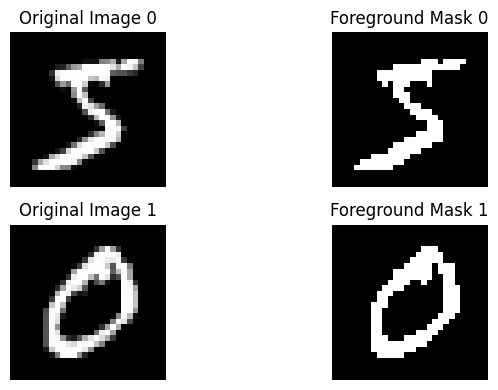

In [7]:
# Displaying the first 2 images and their foreground masks
plt.figure(figsize=(8, 4))

for i in range(2):
    # Original Images
    plt.subplot(2, 2, 2 * i + 1)
    plt.imshow(images[i], cmap='gray')
    plt.title(f"Original Image {i}")
    plt.axis('off')
    
    # Foreground Masks
    plt.subplot(2, 2, 2 * i + 2)
    plt.imshow(foreground_masks[i], cmap='gray')
    plt.title(f"Foreground Mask {i}")
    plt.axis('off')

plt.tight_layout()
plt.show()

In [ ]:
# Task (b): Obtaining the Tight Ground Truth Circles Around Foreground Masks
circle_images = []

for mask in tqdm(foreground_masks):
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)  # Find contours in the mask
    # If contours are found, drawing the minimum enclosing circle
    if contours:
        c = max(contours, key=cv2.contourArea)
        (x, y), radius = cv2.minEnclosingCircle(c)
        circle_mask = np.zeros_like(mask)
        cv2.circle(circle_mask, (int(x), int(y)), int(radius), 255, -1)
        circle_images.append(circle_mask)
    else:
        circle_images.append(np.zeros_like(mask)) # If no contours, appending an empty mask


100%|██████████| 60000/60000 [00:01<00:00, 40101.36it/s]


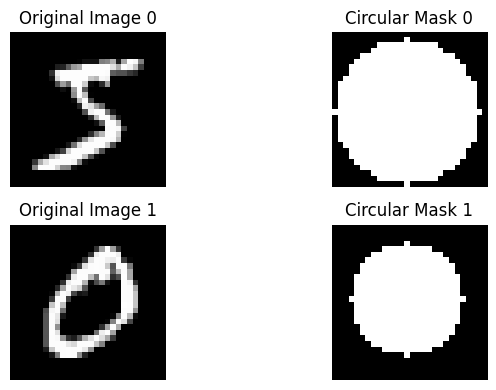

In [10]:

# Converting the circle_images to NumPy array
circle_images = np.array(circle_images)

# Displaying first 2 samples: original image and circular mask
plt.figure(figsize=(8, 4))

for i in range(2):
    # Original Image
    plt.subplot(2, 2, 2 * i + 1)
    plt.imshow(images[i], cmap='gray')
    plt.title(f"Original Image {i}")
    plt.axis('off')
    
    # Circular Mask
    plt.subplot(2, 2, 2 * i + 2)
    plt.imshow(circle_images[i], cmap='gray')
    plt.title(f"Circular Mask {i}")
    plt.axis('off')

plt.tight_layout()
plt.show()


In [ ]:
# Task (c): Spatially Concatenating Randomly Chosen Images and Masks in a 2x2 Grid
def create_concatenated_images(images, masks):
    concatenated_images = []
    concatenated_masks = []
    for _ in range(len(images) // 4):
        indices = random.sample(range(len(images)), 4)  # Randomly pick 4 images
        imgs = [images[i] for i in indices]
        msks = [masks[i] for i in indices]
        
        # Creating the 2x2 grid of images and masks
        img_grid = np.vstack([np.hstack(imgs[:2]), np.hstack(imgs[2:])])
        mask_grid = np.vstack([np.hstack(msks[:2]), np.hstack(msks[2:])])
        
        concatenated_images.append(img_grid)
        concatenated_masks.append(mask_grid)
    
    return concatenated_images, concatenated_masks

concatenated_images, concatenated_masks = create_concatenated_images(images, foreground_masks)

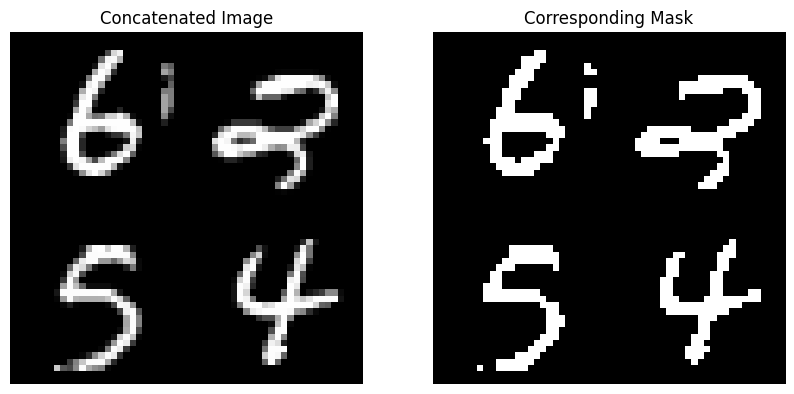

In [12]:

# Displaying one example (first image and mask) for part 3 of question
example_image = concatenated_images[0]  # Remove channel dimension
example_mask = concatenated_masks[0]    # Remove channel dimension

# Plotting the image and mask
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.title("Concatenated Image")
plt.imshow(example_image, cmap='gray')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title("Corresponding Mask")
plt.imshow(example_mask, cmap='gray')
plt.axis('off')

plt.show()

## Question 2

In [ ]:
## Defining the Dataset to store the data for training

class ForegroundSegmentationDataset(Dataset):
    def __init__(self, images, masks, transform=None):
        self.images = images
        self.masks = masks
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx].astype('float32')/255.0    #normalising both values by dividing by 255.0 
        mask = self.masks[idx].astype('float32')/255.0     #and converting to float32 
        
        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)
        
        return image, mask


transform = transforms.Compose([
    transforms.ToTensor()
])
dataset = ForegroundSegmentationDataset(images, foreground_masks, transform=transform) # Converting images and masks to pytorch dataset

# Splitting the data into training and test sets
train_size = int(0.8 * len(dataset))    # 80% for training and 20% for testing
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size]) 

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True) ## DataLoader for training set
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)  ## DataLoader for testing set


In [ ]:

##Defining the SimpleUnet architecture for model
class SimpleUNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.enc1 = nn.Sequential(nn.Conv2d(1, 16, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2)) # First encoder layer
        self.enc2 = nn.Sequential(nn.Conv2d(16, 32, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2)) # Second encoder layer

        self.dec1 = nn.Sequential(nn.ConvTranspose2d(32, 16, 2, stride=2), nn.ReLU())    # First decoder layer
        self.dec2 = nn.Sequential(nn.ConvTranspose2d(16, 1, 2, stride=2), nn.Sigmoid())  # Second decoder layer

    def forward(self, x):  # Forward pass through the network
        x1 = self.enc1(x)
        x2 = self.enc2(x1)
        x = self.dec1(x2)
        x = self.dec2(x)
        return x          # Final output of the network

In [ ]:
model = SimpleUNet()     # Defining the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") #Using GPU if available
model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)     # Using Adam optimizer for training
criterion = nn.BCELoss()                                     # Using the Binary Cross Entropy Loss

for epoch in range(10):               # Training the model for 10 epochs
    model.train()
    epoch_loss = 0
    for imgs, masks in train_loader:
        imgs, masks = imgs.to(device), masks.to(device)
        preds = model(imgs)                      # Forward pass through the model
        loss = criterion(preds, masks)        ## Calculating the loss
        optimizer.zero_grad()           
        loss.backward()                    # Backpropagation
        optimizer.step()
        epoch_loss += loss.item()
    print(f"Epoch {epoch+1}, Loss: {epoch_loss:.4f}")


Epoch 1, Loss: 102.7697
Epoch 2, Loss: 52.3311
Epoch 3, Loss: 47.7329
Epoch 4, Loss: 44.8788
Epoch 5, Loss: 42.7318
Epoch 6, Loss: 40.9598
Epoch 7, Loss: 39.4320
Epoch 8, Loss: 38.1440
Epoch 9, Loss: 37.0451
Epoch 10, Loss: 36.0626


In [ ]:
##Here I have calculated the IoU metric using the predefined sklearn jaccard similarity metric
model.eval()
ious = []
with torch.no_grad():
    for img, mask in test_loader:
        img, mask = img.to(device), mask.to(device)
        pred = model(img).round()       # Getting the predicted mask
        iou = jaccard_score(mask.cpu().numpy().flatten(), pred.cpu().numpy().flatten(), average="micro") #
        ious.append(iou)                # Calculating the IoU for each batch and appending them

print("Mean IoU:", np.mean(ious))       # Mean IoU for the test set

Mean IoU: 0.9808741805573532


In [ ]:
#Here I have calculated the IoU metric by defining it myself
def compute_iou(preds, targets, threshold=0.5):
    preds = (preds > threshold).float()        # Applying threshold to predictions
    intersection = (preds * targets).sum(dim=(1,2,3))  # Intersection between predicted and target masks
    union = (preds + targets - preds * targets).sum(dim=(1,2,3)) # Union of predicted and target masks
    iou = (intersection + 1e-6) / (union + 1e-6)  # Adding small value to avoid division by zero
    return iou.mean().item()  # Mean IoU for the batch

model.eval()
total_iou = 0
with torch.no_grad():
    for imgs, masks in test_loader:
        imgs, masks = imgs.to(device), masks.to(device)
        preds = model(imgs)
        total_iou += compute_iou(preds, masks) # Calculating IoU for each batch

average_iou = total_iou / len(test_loader)   # Mean IoU for the test set
print(f"Test IoU: {average_iou:.4f}")


Test IoU: 0.9311


## Question 3

In [ ]:
## Definig the dataset for Q3
class CircleClassificationDataset(Dataset):
    def __init__(self, images, labels, circle_masks, transform=None):
        self.images = images
        self.labels = labels
        self.circle_masks = circle_masks
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img = self.images[idx]/255.0  # Normalizing the image to [0, 1] range
        label = self.labels[idx]
        circle_mask = self.circle_masks[idx]/255.0  # Normalizing the mask to [0, 1] range

        if self.transform:
            img = self.transform(img)

        img = torch.tensor(img, dtype=torch.float32).unsqueeze(0)
        label = torch.tensor(label, dtype=torch.long)
        circle_mask = torch.tensor(circle_mask, dtype=torch.float32).unsqueeze(0)

        return img, label, circle_mask


In [ ]:
import torch
import torch.nn as nn

##It is also very similar to Unet architecture
class CircleNet(nn.Module):
    def __init__(self):
        super().__init__()

        # Defining the Encoder
        self.enc1 = nn.Sequential(
            nn.Conv2d(1, 16, 3, padding=1), nn.ReLU() # (B, 16, 28, 28)
        )
        self.pool1 = nn.MaxPool2d(2) # (B, 16, 14, 14)

        self.enc2 = nn.Sequential(
            nn.Conv2d(16, 32, 3, padding=1), nn.ReLU() 
        )
        self.pool2 = nn.MaxPool2d(2)  # (B, 32, 7, 7)

        # Classifier head(Used for classification task)
        # The output of the encoder is flattened and passed through a linear layer
        # to get the class logits.
        self.classifier = nn.Linear(32 * 7 * 7, 10)

        # Defining the Decoder
        self.up1 = nn.ConvTranspose2d(32, 32, 2, stride=2)  
        self.dec1 = nn.Sequential(
            nn.Conv2d(32 + 32, 32, 3, padding=1), nn.ReLU() 
        )

        self.up2 = nn.ConvTranspose2d(32, 16, 2, stride=2)  
        self.dec2 = nn.Sequential(
            nn.Conv2d(16 + 16, 16, 3, padding=1), nn.ReLU() 
        )

        self.final_mask = nn.Conv2d(16, 1, 1) 

    def forward(self, x):  # Forward pass through the network
        # Input shape: (B, 1, 28, 28)
        # Encoding
        x1 = self.enc1(x)             # (B, 16, 28, 28)
        x2 = self.enc2(self.pool1(x1))# (B, 32, 14, 14)
        feat = self.pool2(x2)         # (B, 32, 7, 7)

        # Classification output
        class_logits = self.classifier(feat.view(x.size(0), -1))

        # Decoding
        up1 = self.up1(feat)                  # (B, 32, 14, 14)
        concat1 = torch.cat([up1, x2], dim=1) # (B, 64, 14, 14)
        dec1 = self.dec1(concat1)             # (B, 32, 14, 14)

        up2 = self.up2(dec1)                  # (B, 16, 28, 28)
        concat2 = torch.cat([up2, x1], dim=1) # (B, 32, 28, 28)
        dec2 = self.dec2(concat2)             # (B, 16, 28, 28)

        mask_logits = self.final_mask(dec2)   # (B, 1, 28, 28)

        return class_logits, mask_logits # Final output of the network
     #model returns two outputs: class logits and mask logits


In [ ]:

##Converting the data into test and train set and defining the train and test loader
circle_mask=np.array(circle_images)

train_imgs, test_imgs, train_labels, test_labels, train_masks, test_masks = train_test_split(
    images, labels, circle_mask, test_size=0.2, random_state=42) # Splitting the data into training and test sets

train_dataset = CircleClassificationDataset(train_imgs, train_labels, train_masks) # Converting images and masks to pytorch dataset
test_dataset = CircleClassificationDataset(test_imgs, test_labels, test_masks)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)  # DataLoader for training set
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)   # DataLoader for testing set


In [ ]:

# Initializing the model
model = CircleNet()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Loss functions
class_criterion = nn.CrossEntropyLoss()  #loss function for classification task
circle_criterion = nn.BCEWithLogitsLoss() # loss function for circleization task


# Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 20


for epoch in range(num_epochs): # Training the model for 20 epochs
    model.train()
    train_loss = 0

    for images, labels, circle_masks in train_loader:
        images = images.to(device)
        labels = labels.to(device)
        circle_masks = circle_masks.to(device)

        optimizer.zero_grad()

        class_logits, circle_pred = model(images) # Forward pass through the model

        class_loss = class_criterion(class_logits, labels) # Calculating the classification loss
        circle_loss = circle_criterion(circle_pred, circle_masks) # Calculating the circleization loss

        total_loss = class_loss + 1000 * circle_loss # Total loss is a weighted sum of classification and circleization losses

        total_loss.backward() # Backpropagation
        optimizer.step()

        train_loss += total_loss.item()

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {train_loss/len(train_loader):.4f}")


Epoch 1/20, Loss: 264.4117
Epoch 2/20, Loss: 207.1718
Epoch 3/20, Loss: 195.6364
Epoch 4/20, Loss: 188.1268
Epoch 5/20, Loss: 182.9128
Epoch 6/20, Loss: 179.3719
Epoch 7/20, Loss: 176.6446
Epoch 8/20, Loss: 174.2687
Epoch 9/20, Loss: 172.1891
Epoch 10/20, Loss: 170.1382
Epoch 11/20, Loss: 168.5611
Epoch 12/20, Loss: 167.2487
Epoch 13/20, Loss: 165.7913
Epoch 14/20, Loss: 164.6639
Epoch 15/20, Loss: 163.3861
Epoch 16/20, Loss: 162.2811
Epoch 17/20, Loss: 161.4145
Epoch 18/20, Loss: 160.3966
Epoch 19/20, Loss: 159.8333
Epoch 20/20, Loss: 158.6495


In [ ]:
def compute_iou(pred_mask, true_mask, threshold=0.5): # Function to compute IoU
    pred_bin = (pred_mask > threshold).float() # Binarizing the predicted mask
    intersection = (pred_bin * true_mask).sum() # Intersection between predicted and true masks
    union = ((pred_bin + true_mask) > 0).float().sum() # Union of predicted and true masks
    return (intersection / union).item() if union != 0 else 0.0 # Avoid division by zero

model.eval()
iou_scores = []

with torch.no_grad():
    for images, labels, circle_masks in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        circle_masks = circle_masks.to(device)  

        class_logits, circle_pred = model(images)  # Forward pass through the model
        preds = class_logits.argmax(dim=1)         # Getting the predicted class labels

        for i in range(images.size(0)):           ## Looping through each image in the batch
            iou = 0.0
            if preds[i] == labels[i]:            # If the predicted class matches the true class
                # Compute IoU only for the correct predictions
                iou = compute_iou(circle_pred[i], circle_masks[i])
            iou_scores.append(iou)

mean_iou = sum(iou_scores) / len(iou_scores)  # Mean IoU for the test set
print(f"\nTest IoU (classification-aware): {mean_iou:.4f}")



Test IoU (classification-aware): 0.8339


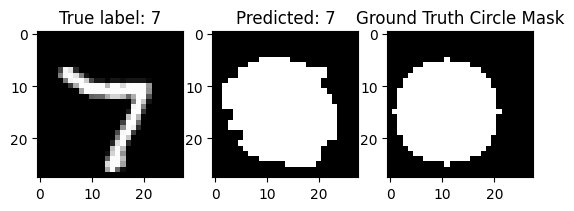

In [44]:
import matplotlib.pyplot as plt

model.eval()
images, labels, true_masks = next(iter(test_loader))
images = images.to(device)
labels = labels.to(device)
true_masks = true_masks.to(device)

with torch.no_grad():
    logits, pred_masks = model(images)
    preds = logits.argmax(dim=1)

i = 0  # checking first image
plt.subplot(1, 3, 1)
plt.title(f"True label: {labels[i].item()}")
plt.imshow(images[i].cpu().squeeze(), cmap='gray')

plt.subplot(1, 3, 2)
plt.title(f"Predicted: {preds[i].item()}")
plt.imshow(torch.sigmoid(pred_masks[i]).cpu().squeeze().numpy() > 0.5, cmap='gray')

plt.subplot(1, 3, 3)
plt.title("Ground Truth Circle Mask")
plt.imshow(true_masks[i].cpu().squeeze(), cmap='gray')
plt.show()


## Question 4

In [ ]:
## Dataset preparation

class ConcatenatedMNISTDataset(Dataset):
    def __init__(self, images, masks, transform=None):
        self.images = images
        self.masks = masks
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx] / 255.0  # Normalizing the image to [0, 1] range
        mask = self.masks[idx] / 255.0    # Normalizing the mask to [0, 1] range

        image = torch.tensor(image, dtype=torch.float32).unsqueeze(0)  # (1, H, W)
        mask = torch.tensor(mask, dtype=torch.float32).unsqueeze(0)    # (1, H, W)

        return image, mask


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class segmentation_model(nn.Module): # Segmentation model for the concatenated images
    def __init__(self):
        super().__init__()

        # Encoder
        self.enc1 = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, padding=1),
            nn.ReLU(),
        )
        self.pool1 = nn.MaxPool2d(2)  # 56x56 → 28x28

        self.enc2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.ReLU(),
        )
        self.pool2 = nn.MaxPool2d(2)  # 28x28 → 14x14

        # Bottleneck layer 
        self.bottleneck = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
        )

        # Decoder
        self.up1 = nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2)  # 14x14 → 28x28
        self.dec1 = nn.Sequential(
            nn.Conv2d(64, 32, kernel_size=3, padding=1),
            nn.ReLU(),
        )

        self.up2 = nn.ConvTranspose2d(32, 16, kernel_size=2, stride=2)  # 28x28 → 56x56
        self.dec2 = nn.Sequential(
            nn.Conv2d(32, 16, kernel_size=3, padding=1),
            nn.ReLU(),
        )

        # Final output layer
        self.final = nn.Conv2d(16, 1, kernel_size=1)

    def forward(self, x):
        # Encoder
        x1 = self.enc1(x)         # (B, 16, 56, 56)
        x1p = self.pool1(x1)      # (B, 16, 28, 28)

        x2 = self.enc2(x1p)       # (B, 32, 28, 28)
        x2p = self.pool2(x2)      # (B, 32, 14, 14)

        # Bottleneck
        x3 = self.bottleneck(x2p) # (B, 64, 14, 14)

        # Decoder
        up1 = self.up1(x3)        # (B, 32, 28, 28)
        merge1 = torch.cat([up1, x2], dim=1)  # (B, 64, 28, 28)
        dec1 = self.dec1(merge1)  # (B, 32, 28, 28)

        up2 = self.up2(dec1)      # (B, 16, 56, 56)
        merge2 = torch.cat([up2, x1], dim=1)  # (B, 32, 56, 56)
        dec2 = self.dec2(merge2)  # (B, 16, 56, 56)

        out = self.final(dec2)    # (B, 1, 56, 56)
        return out


In [ ]:
concatenated_images=np.array(concatenated_images)
concatenated_masks=np.array(concatenated_masks)    # Converting the concatenated images and masks to NumPy arrays
# Splitting the data into training and test sets
train_segimgs, test_segimgs, train_segmasks, test_segmasks = train_test_split(
    concatenated_images, concatenated_masks, test_size=0.2, random_state=42)

train_dataset = ConcatenatedMNISTDataset(train_segimgs, train_segmasks)  # Converting images and masks to pytorch dataset
test_dataset = ConcatenatedMNISTDataset(test_segimgs, test_segmasks)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)   # DataLoader for training set
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)    # DataLoader for testing set

In [ ]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = segmentation_model().to(device)
criterion = nn.BCEWithLogitsLoss()   # Loss function for segmentation
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)  # Optimizer for training

# Training
for epoch in range(10):
    model.train()
    total_loss = 0
    for images, masks in train_loader:
        images, masks = images.to(device), masks.to(device)
        optimizer.zero_grad()

        logits = model(images)  # Forward pass through the model
        loss = criterion(logits, masks) # Calculating the loss
        loss.backward()   # Backpropagation
        optimizer.step()
        total_loss += loss.item()

    print(f"Epoch {epoch+1}, Loss: {total_loss/len(train_loader):.4f}")


Epoch 1, Loss: 0.0459
Epoch 2, Loss: 0.0076
Epoch 3, Loss: 0.0046
Epoch 4, Loss: 0.0035
Epoch 5, Loss: 0.0030
Epoch 6, Loss: 0.0027
Epoch 7, Loss: 0.0025
Epoch 8, Loss: 0.0024
Epoch 9, Loss: 0.0023
Epoch 10, Loss: 0.0022


In [ ]:
def dice_coefficient(preds, targets, threshold=0.5): # Function to compute Dice Coefficient
    preds = (preds > threshold).float()             # Binarizing the predicted mask
    intersection = (preds * targets).sum()          # Intersection between predicted and target masks
    return (2. * intersection) / (preds.sum() + targets.sum() + 1e-8)  # Adding small value to avoid division by zero


In [ ]:
model.eval()  # Evaluating the model on the test set
dice_scores = []

with torch.no_grad():
    for images, masks in test_loader:
        images, masks = images.to(device), masks.to(device)
        preds = torch.sigmoid(model(images))  # Getting the predicted masks
        dice = dice_coefficient(preds, masks) # Calculating the Dice Coefficient for each batch 
        dice_scores.append(dice.item())      # Appending the Dice Coefficient to the list

print(f"Test Dice Coefficient: {sum(dice_scores)/len(dice_scores):.4f}")


Test Dice Coefficient: 0.9969


## Question 5

In [12]:
# ---------- Parameters ----------
video_path = '/kaggle/input/image-video/q5/denis_walk.avi'
background_image_path = '/kaggle/input/image-video/q5/bg.png'
output_path = 'output_video.avi'


In [13]:
import matplotlib.pyplot as plt
from IPython.display import display, clear_output

In [ ]:

# ---------- Parameters ----------

background_estimation_frames = 30
diff_threshold = 25  # Lowered threshold to capture subtle differences
min_contour_area = 500  # Removing small blobs (noise)
frames_to_display = 5

# ---------- Loading Video and Background ----------
cap = cv2.VideoCapture(video_path)
if not cap.isOpened():
    raise Exception("Error opening video!")

frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
fps = cap.get(cv2.CAP_PROP_FPS)

# Loading and resizing new background
new_background = cv2.imread(background_image_path)
new_background = cv2.resize(new_background, (frame_width, frame_height))

# ---------- Step 1: Estimating the Background ----------
background_accum = np.zeros((frame_height, frame_width, 3), dtype=np.float32) # Accumulator for background
# Reading the first few frames to estimate the background
cap.set(cv2.CAP_PROP_POS_FRAMES, 0)

for i in range(background_estimation_frames):
    ret, frame = cap.read()
    if not ret:
        break
    background_accum += frame.astype(np.float32)      # Accumulating the frames

static_background = (background_accum / background_estimation_frames).astype(np.uint8) # Average background

# ---------- Resetting the Video ----------
cap.set(cv2.CAP_PROP_POS_FRAMES, 0) # Resetting to the start of the video
out = cv2.VideoWriter(output_path, cv2.VideoWriter_fourcc(*'XVID'), fps, (frame_width, frame_height)) # Output video writer



# ---------- Processing the Frames ----------
while True:
    ret, frame = cap.read()
    if not ret:
        break

    # Getting diff and grayscale
    diff = cv2.absdiff(frame, static_background)
    diff_gray = cv2.cvtColor(diff, cv2.COLOR_BGR2GRAY)

    # Threshold to get rough foreground mask
    _, mask = cv2.threshold(diff_gray, diff_threshold, 255, cv2.THRESH_BINARY)

    # Morphological filtering
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))  # Structuring element for morphological operations
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel, iterations=2) #  Closing to fill gaps
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel, iterations=1) # Opening to remove noise
    mask = cv2.dilate(mask, kernel, iterations=3)  # Dilation to enhance the foreground
    mask = cv2.erode(mask, kernel, iterations=2)   # Erosion to reduce noise

    # Filtering out small blobs (non-human)
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE) # Finding contours in the mask
    refined_mask = np.zeros_like(mask)  # Creating a refined mask
    for cnt in contours: # Looping through each contour
        if cv2.contourArea(cnt) > min_contour_area:     # Filtering based on area
            cv2.drawContours(refined_mask, [cnt], -1, 255, -1)

    # Converting to 3-channel mask
    mask_3ch = cv2.merge([refined_mask] * 3)
    inv_mask = cv2.bitwise_not(mask_3ch)

    # Composite
    foreground = cv2.bitwise_and(frame, mask_3ch)  # Foreground extraction
    background = cv2.bitwise_and(new_background, inv_mask) # Background replacement
    final_frame = cv2.add(foreground, background)  # Final composite frame

    out.write(final_frame)


cap.release()
out.release()
print("✅ Done! Final video saved as:", output_path)



✅ Done! Final video saved as: output_video.avi
